In [217]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 22, 'grid.linestyle': '-', 'grid.color': 'gray' })


In [218]:
dataset_raw_file = "../data/output/dataset_raw.tsv"
datase_file = "../data/output/dataset.tsv"
references_dir = "../data/output/references"
ncbi_tax_file = "../data/new_taxdump/rankedlineage.dmp"

# Output
fig_dir = "../data/output/references_stat"

In [219]:
tuples = []
for reference_file in os.listdir(references_dir):
    with open("{}/{}".format(references_dir, reference_file)) as f:
        data = {}
        reference_name = reference_file.split(".")[0]
        group = None
        for k in ['linker', 'binding', 'disorder']:  # order matters
            if k in reference_name:
                group = k
                break
        for line in f:
            if line:
                if line[0] == ">":
                    name = line.strip()[1:]
                    data.setdefault(name, [])
                else:
                    data[name].append(list(line.strip()))
        for name in data:
            for i, (aa, val) in enumerate(zip(*data[name])):
                tuples.append((group, reference_name, name, i + 1, aa, val))
df_references = pd.DataFrame(tuples, columns=['group', 'reference', 'disprot_id', 'pos', 'aa', 'value'])
df_references.set_index(['group', 'reference', 'disprot_id', 'pos', 'aa'], inplace=True)
df_references

value
group    reference         disprot_id pos  aa      
linker   linker            DP02418    1    M      0
                                      2    A      0
                                      3    S      0
                                      4    P      0
                                      5    P      0
...                                             ...
disorder disorder_pdb_fill DP03746    1280 Q      1
                                      1281 L      1
                                      1282 L      1
                                      1283 I      1
                                      1284 R      1

[1238989 rows x 1 columns]

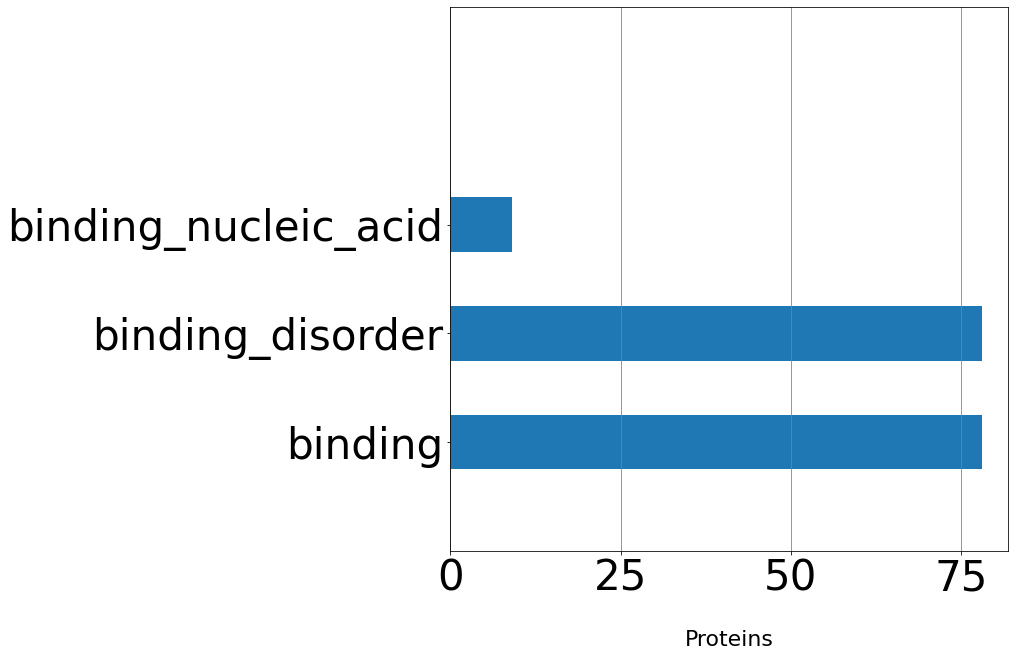

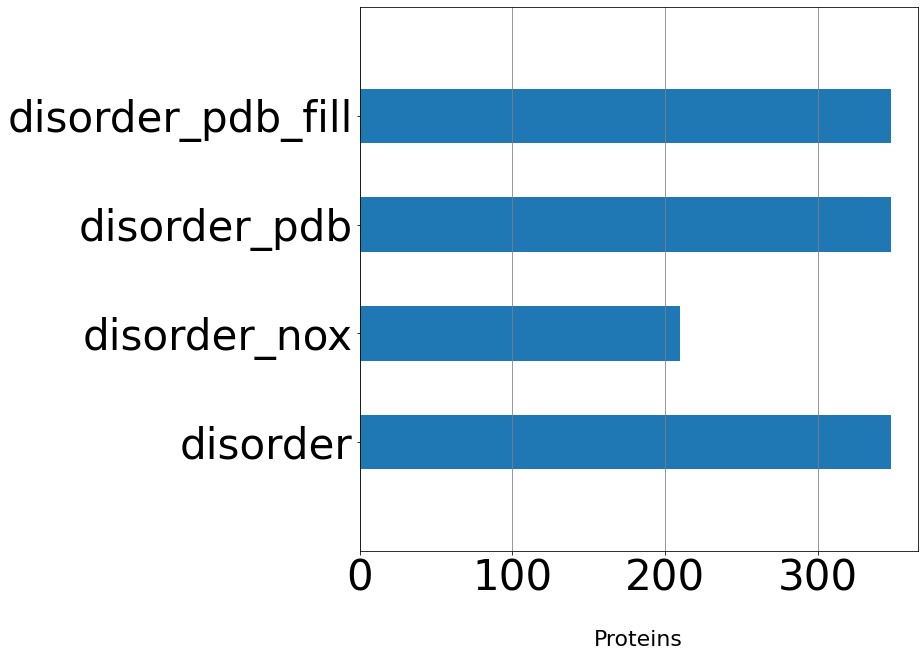

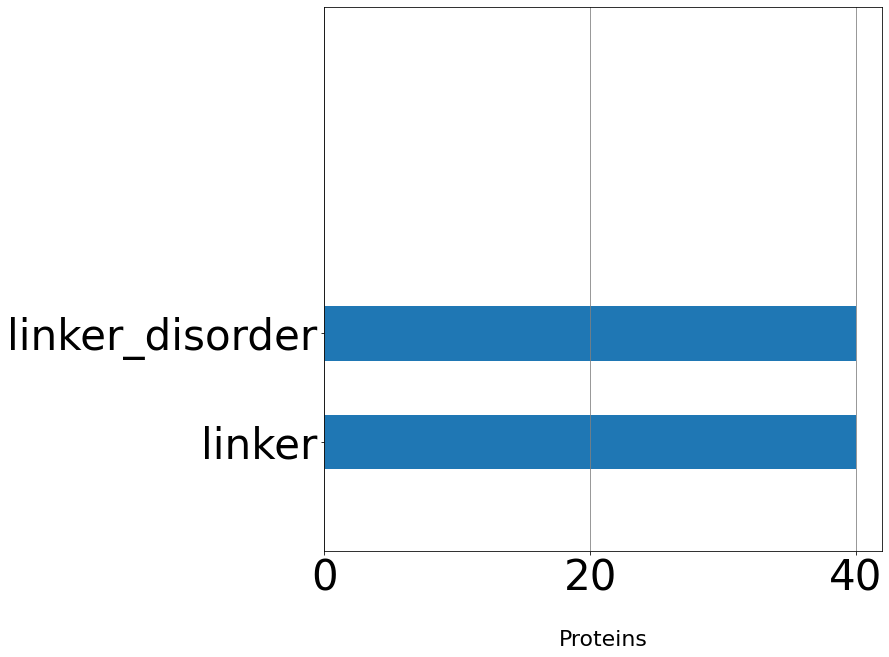

In [220]:
for group, df_g in df_references.groupby(level='group'):
    df2 = df_g.reset_index(level='disprot_id').groupby(['reference'])['disprot_id'].nunique().reset_index().set_index('reference')
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', width=0.5, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.get_legend().remove()
    ax.set_xlabel('Proteins', labelpad=30)

    fig.gca().set_ylabel("")
    # fig.savefig("{}/stat_proteins_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

In [221]:
idx = pd.IndexSlice
df_references.loc[idx[:, ['disorder', 'linker', 'binding', 'binding_nucleic_acid'], :, :, :], :]
# df_references.index.get_level_values('reference').unique()

value
group    reference            disprot_id pos  aa      
disorder disorder             DP02342    1    M      1
                                         2    L      1
                                         3    C      1
                                         4    C      1
                                         5    M      1
...                                                ...
binding  binding_nucleic_acid DP03669    1308 S      0
                                         1309 V      0
                                         1310 E      0
                                         1311 C      0
                                         1312 R      0

[399828 rows x 1 columns]

Index(['binding_nucleic_acid', 'binding', 'linker', 'disorder'], dtype='object', name='reference')


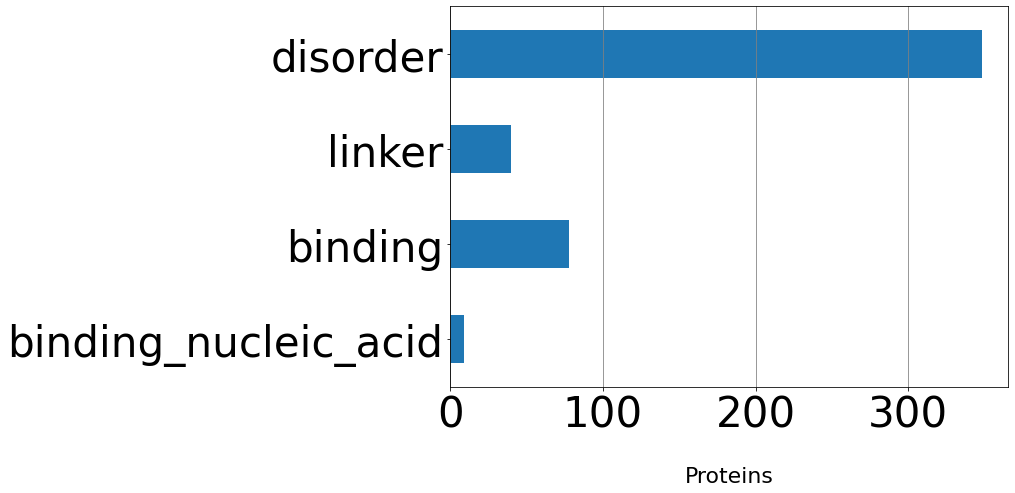

In [222]:
# Proteins
df2 = df_references.loc[idx[:, ['disorder', 'linker', 'binding', 'binding_nucleic_acid'], :, :, :], :]

sorterIndex = dict(zip(['binding_nucleic_acid', 'binding', 'linker', 'disorder'], range(4)))
df2 = df2.reset_index(level='disprot_id').groupby(['reference'])['disprot_id'].nunique().reset_index().set_index('reference').sort_values(by='reference', key=lambda x: x.map(sorterIndex))
print(df2.index.get_level_values('reference').unique())

fig, ax = plt.subplots(figsize=(10, 7))
df2.plot(kind='barh', width=0.5, ax=ax)
ax.xaxis.grid()
# ax.set_ybound(-1, 4)
ax.get_legend().remove()
ax.set_xlabel('Proteins', labelpad=30)

fig.gca().set_ylabel("")
fig.savefig("{}/stat_proteins.png".format(fig_dir), dpi=300, bbox_inches='tight')

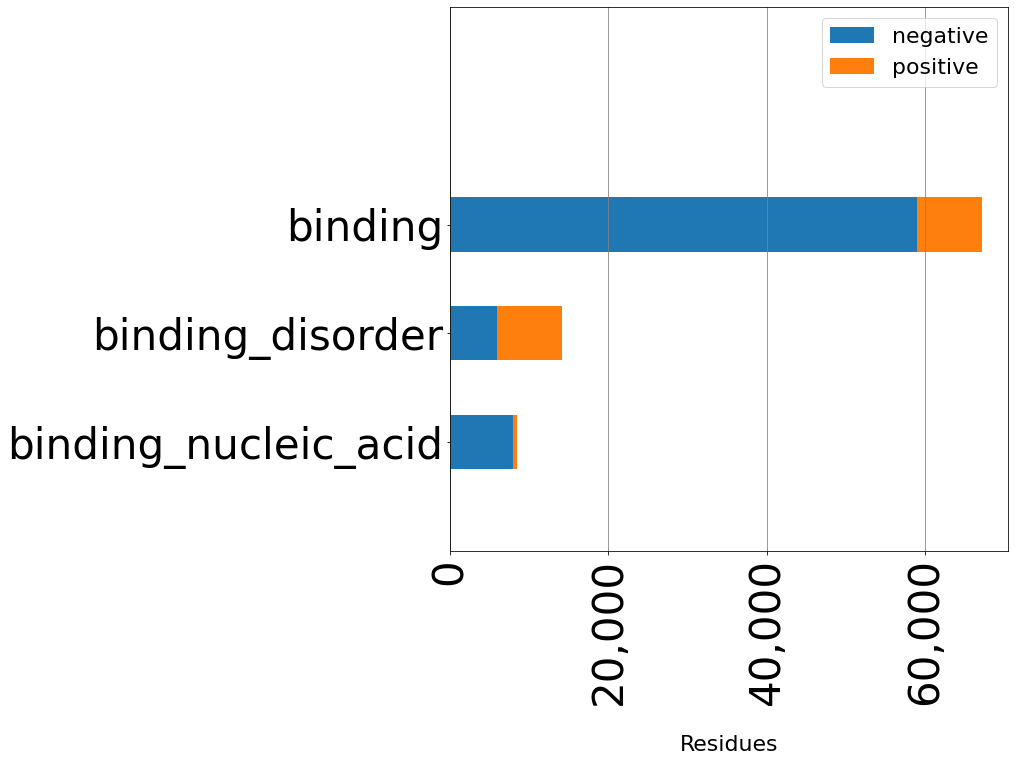

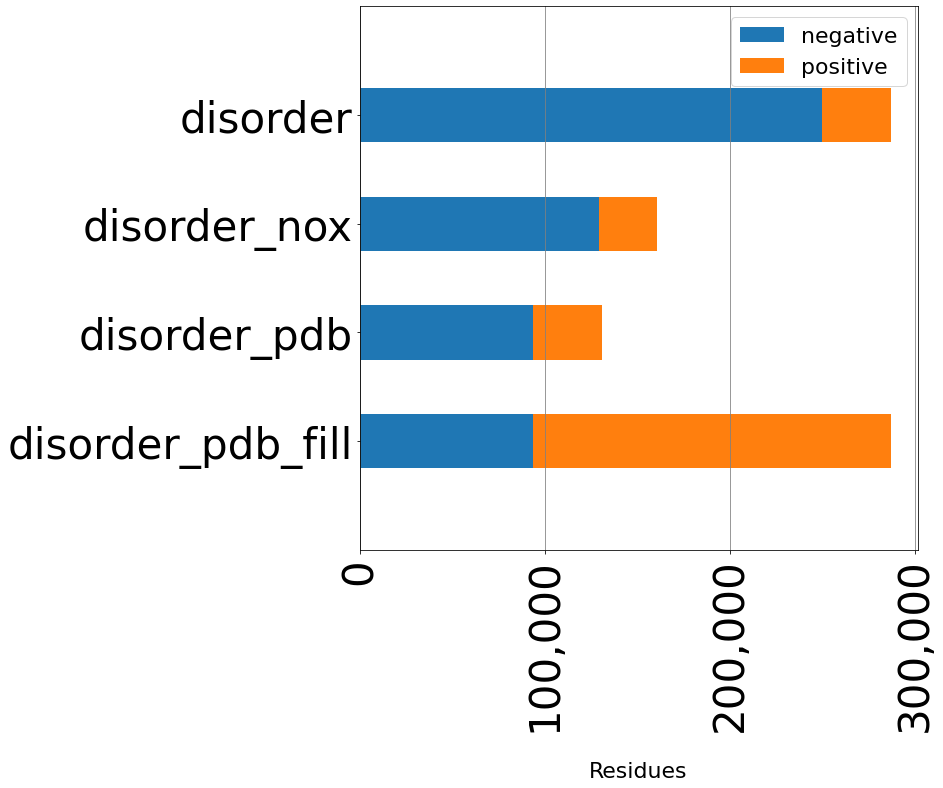

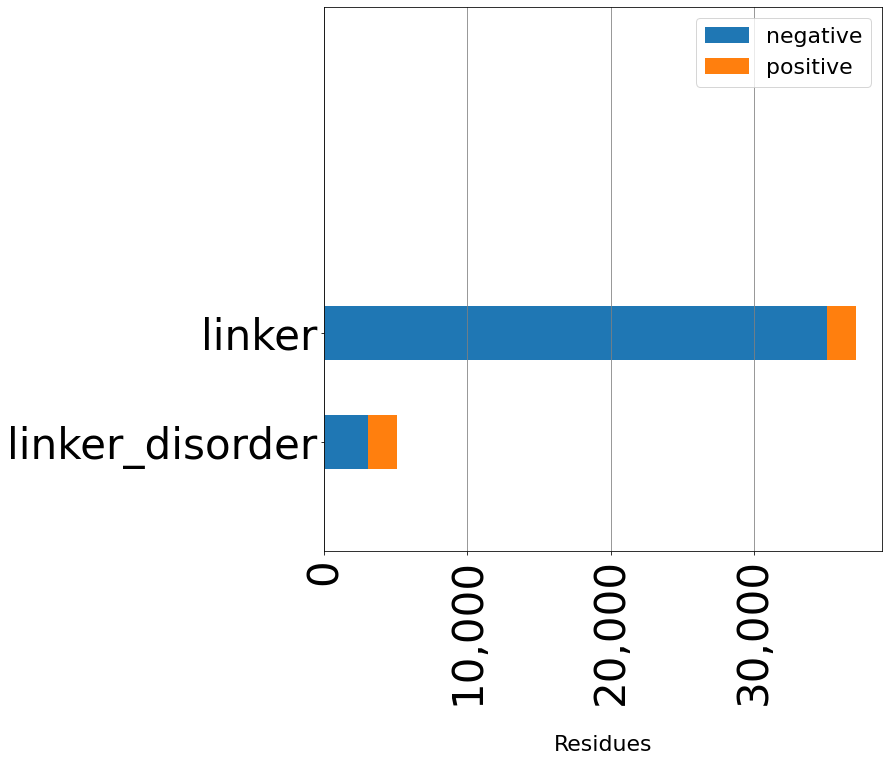

In [223]:
# TODO print the ratio (%) on top of the bars
for group, df_g in df_references.groupby(level='group'):
    df2 = df_g.groupby(['reference'])['value'].value_counts().unstack('value').fillna(0).sort_values(by=['reference'], ascending=[False]).drop(columns=['-'])
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', stacked=True, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.set_xlabel('Residues', labelpad=30)
    ax.xaxis.set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.tick_params(axis='x', labelrotation=90)

    ax.legend(['negative', 'positive'])

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_residues_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

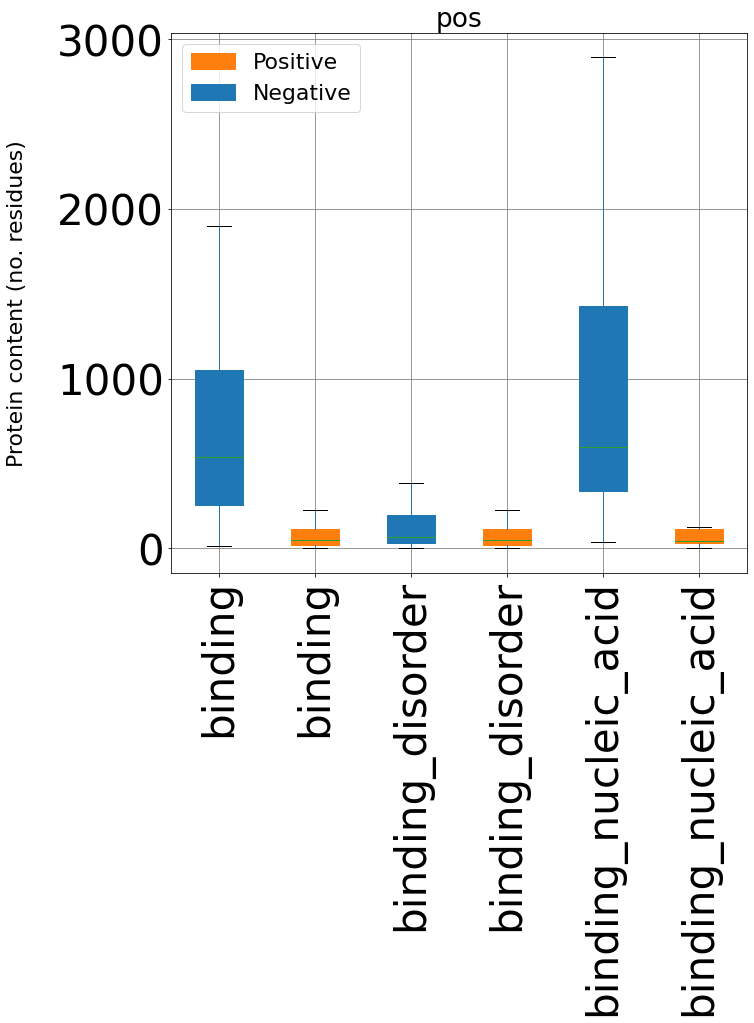

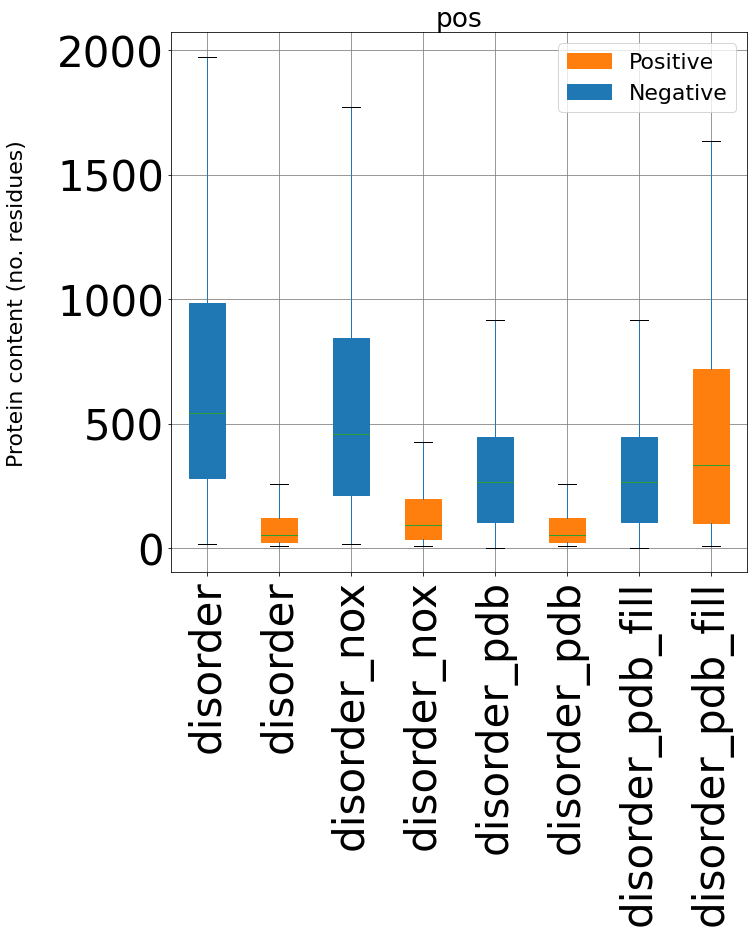

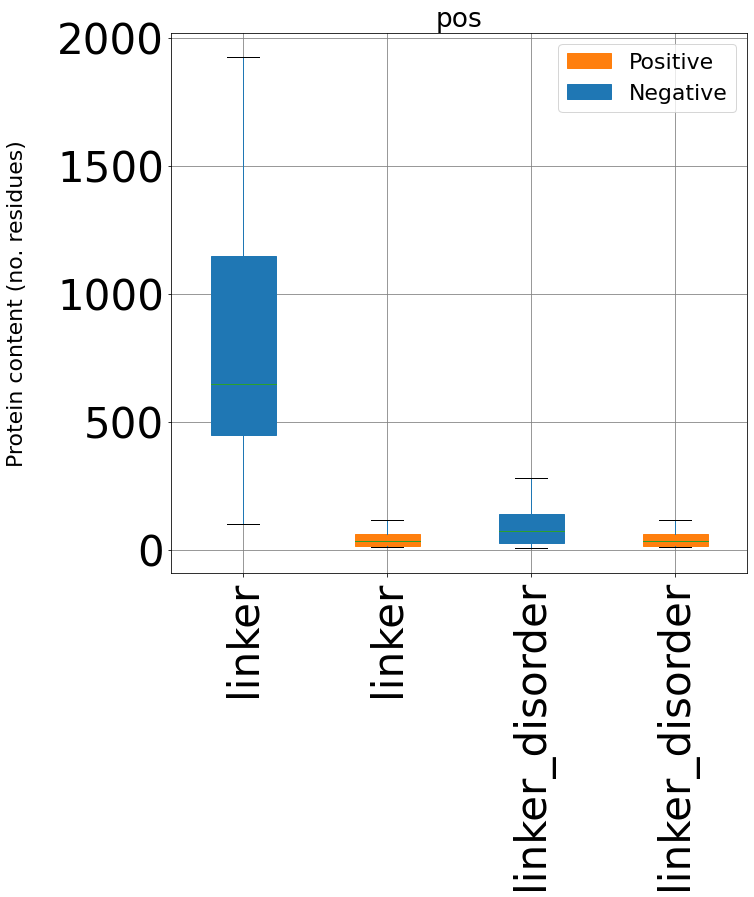

In [224]:
# Content at the protein level
for group, df_g in df_references.reset_index().groupby('group'):
    df_len = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).droplevel('disprot_id').reset_index()
    df_len = df_len.loc[df_len['value'] != '-']
    # print(df_len)

    fig, ax = plt.subplots(figsize=(10, 10))
    bp = df_len.boxplot(by=['reference', 'value'], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
    ax.tick_params(axis='x', labelrotation=90)
    # fill with colors
    colors = {'0': '#1f77b4', '1': '#ff7f0e'}
    for patch, (label, df_g) in zip(bp['pos']['boxes'], df_len.groupby(['reference', 'value'])):
        patch.set_color(colors[label[1]])

    ax.set_ylabel('Protein content (no. residues)', labelpad=30)

    positive = mpatches.Patch(label='Positive', color=colors['1'])
    negative = mpatches.Patch(label='Negative', color=colors['0'])
    ax.legend(handles=[positive, negative])

    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)


    plt.suptitle("")
    # plt.title('')
    fig.gca().set_xlabel("")
    fig.savefig("{}/stat_content_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')
    # break

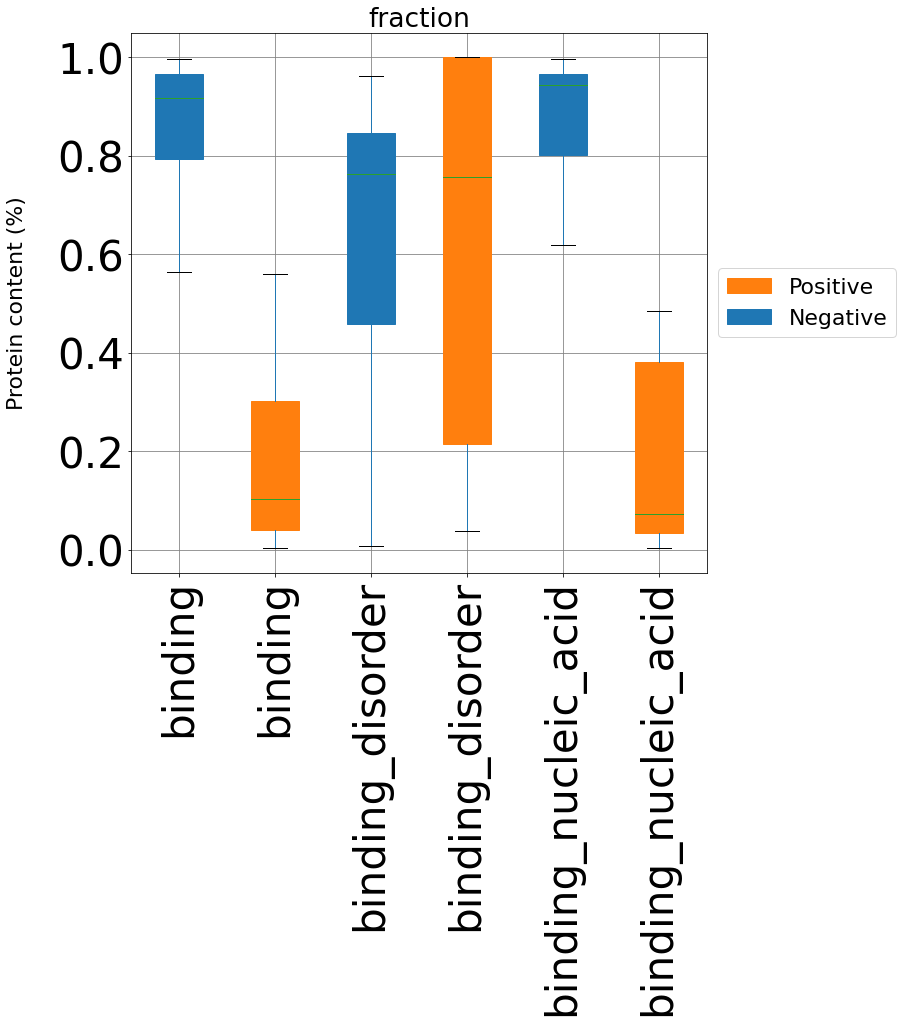

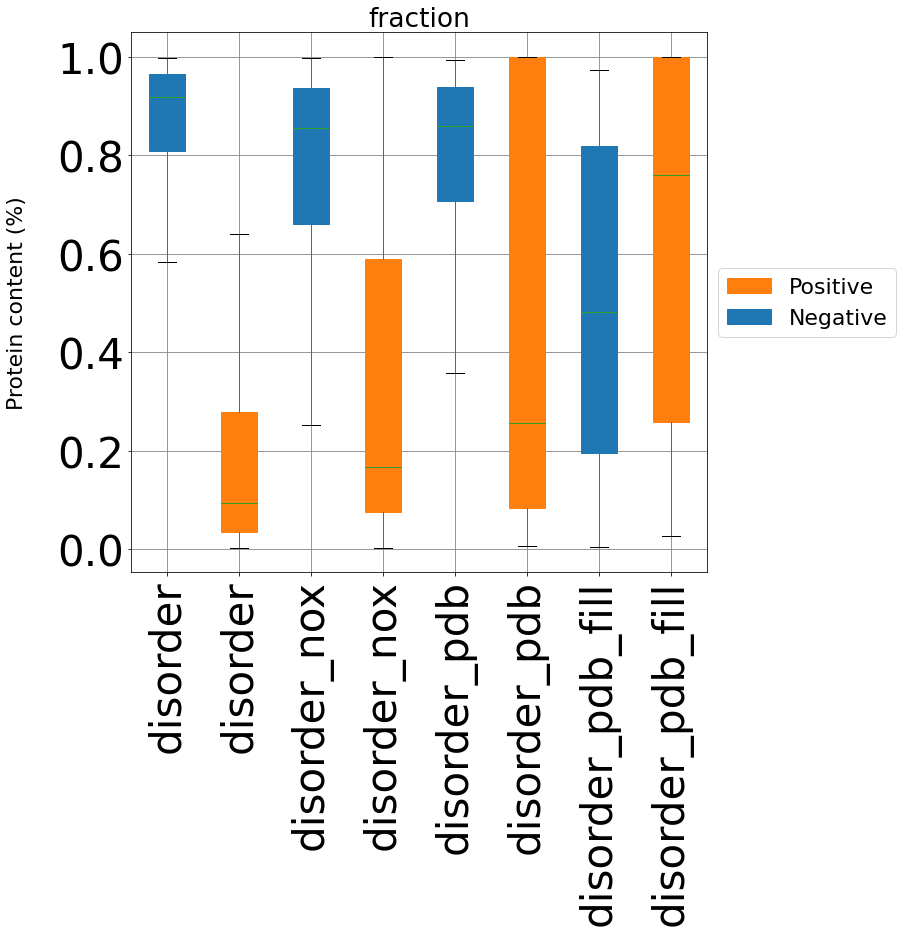

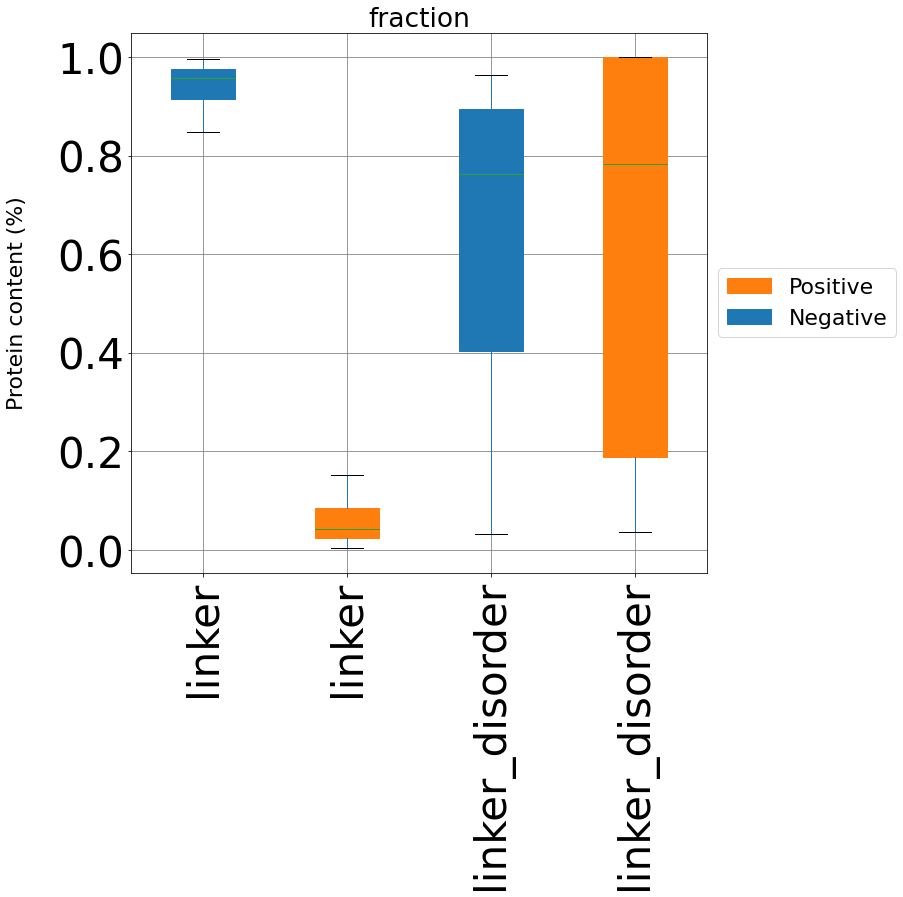

In [225]:
# Content at the protein level
for group, df_g in df_references.reset_index().groupby('group'):
    df_ = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).reset_index()
    df_ = df_.loc[df_['value'] != '-']#.droplevel('disprot_id').reset_index()#.pivot(index='reference', columns='value', values='pos')
    df_tot = df_.groupby(['disprot_id', 'reference']).agg({'pos': 'sum'})
    df_ = pd.merge(df_, df_tot, on=['disprot_id', 'reference'])
    df_['fraction'] = df_['pos_x'] / df_['pos_y']
    # print(df_)

    fig, ax = plt.subplots(figsize=(10, 10))
    bp = df_.loc[:, ['reference', 'value', 'fraction']].boxplot(by=['reference', 'value'], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
    ax.tick_params(axis='x', labelrotation=90)
    # fill with colors
    colors = {'0': '#1f77b4', '1': '#ff7f0e'}
    for patch, (label, df_g) in zip(bp['fraction']['boxes'], df_.groupby(['reference', 'value'])):
        patch.set_color(colors[label[1]])

    ax.set_ylabel('Protein content (%)', labelpad=30)

    positive = mpatches.Patch(label='Positive', color=colors['1'])
    negative = mpatches.Patch(label='Negative', color=colors['0'])
    ax.legend(handles=[positive, negative], loc='center left', bbox_to_anchor=(1.0, 0.5))

    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)

    plt.suptitle("")
    # plt.title('')
    fig.gca().set_xlabel("")
    fig.savefig("{}/stat_content_normalized_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

    # break

In [226]:
df_dataset = pd.read_csv(dataset_raw_file, sep="\t")
df_dataset.columns

Index(['region_id', 'unpublished', 'ec_ontology', 'end', 'term_id', 'start',
       'version', 'statement', 'term_name', 'ec_name', 'curator_orcid',
       'released', 'term_ontology', 'curator_name', 'reference_id', 'date',
       'reference_source', 'term_namespace', 'ec_id', 'curator_id',
       'reference_html', 'ec_go', 'disprot_namespace', 'validated.curator_id',
       'validated.timestamp', 'validated.curator_name', 'term_not_annotate',
       'term_is_obsolete', 'term_comment', 'term_def', 'term_is_binding',
       'interaction_partner', 'cross_refs', 'confidence', 'sample',
       'term_xref', 'construct_alterations', 'sequence_construct',
       'term_go_domain', 'states_connection', 'conditions',
       'annotation_extensions', 'disprot_id', 'acc', 'ncbi_taxon_id',
       'organism', 'sequence', 'challenge'],
      dtype='object')

In [227]:
def expand_region(df_:pd.DataFrame, start_col:str='start', end_col:str='end', res_col:str='reg_position') -> pd.DataFrame:
    df_[res_col] = list(range(int(df_[start_col]), int(df_[end_col]) + 1, 1))
    return df_

In [228]:
df_pos = df_dataset.apply(expand_region, axis=1).explode("reg_position")
df_pos

,region_id,unpublished,ec_ontology,end,term_id,start,version,statement,term_name,ec_name,...,states_connection,conditions,annotation_extensions,disprot_id,acc,ncbi_taxon_id,organism,sequence,challenge,reg_position
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,1
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,2
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,3
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,4
0,DP02342r003,True,ECO,227,IDPO:00078,1,3,[{'text': 'CD spectra of Nm and Ng showed an i...,pre-molten globule,far-UV circular dichroism evidence used in man...,...,NaN,NaN,NaN,DP02342,P06837,10090,Mus musculus,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,disorder,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,413
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,414
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,415
1099,DP03739r012,True,ECO,417,GO:0005516,390,0,"[{'text': 'However, on addition of Calmodulin,...",calmodulin binding,nuclear magnetic resonance spectroscopy eviden...,...,NaN,NaN,NaN,DP03739,P24588,9606,Homo sapiens,METTISEIHVENKDEKRSAEGSPGAERQKEKASMLCFKRRKKAAKA...,binding protein,416


In [229]:
df_ec = pd.merge(df_pos.groupby(['challenge', 'ec_name'], as_index=False)['reg_position'].nunique(), df_pos.groupby(['challenge'], as_index=False)['reg_position'].nunique(), on='challenge').rename({'reg_position_x': 'count', 'reg_position_y': 'total'}, axis=1).sort_values(by=['challenge', 'count'], ascending=[True, True])
df_ec['fraction'] = df_ec['count'] / df_ec['total']
df_ec

,challenge,ec_name,count,total,fraction
23,binding,luciferase reporter gene assay evidence used i...,11,2037,0.005400
32,binding,qualitative western immunoblotting evidence us...,11,2037,0.005400
31,binding,protein kinase assay evidence used in manual a...,12,2037,0.005891
11,binding,deletion mutation phenotypic evidence used in ...,20,2037,0.009818
5,binding,co-immunoprecipitation evidence used in manual...,21,2037,0.010309
...,...,...,...,...,...
136,transition,nuclear magnetic resonance spectroscopy eviden...,415,964,0.430498
127,transition,analytical ultracentrifugation evidence used i...,497,964,0.515560
128,transition,chromatography evidence used in manual assertion,497,964,0.515560
139,transition,x-ray crystallography evidence used in manual ...,529,964,0.548755


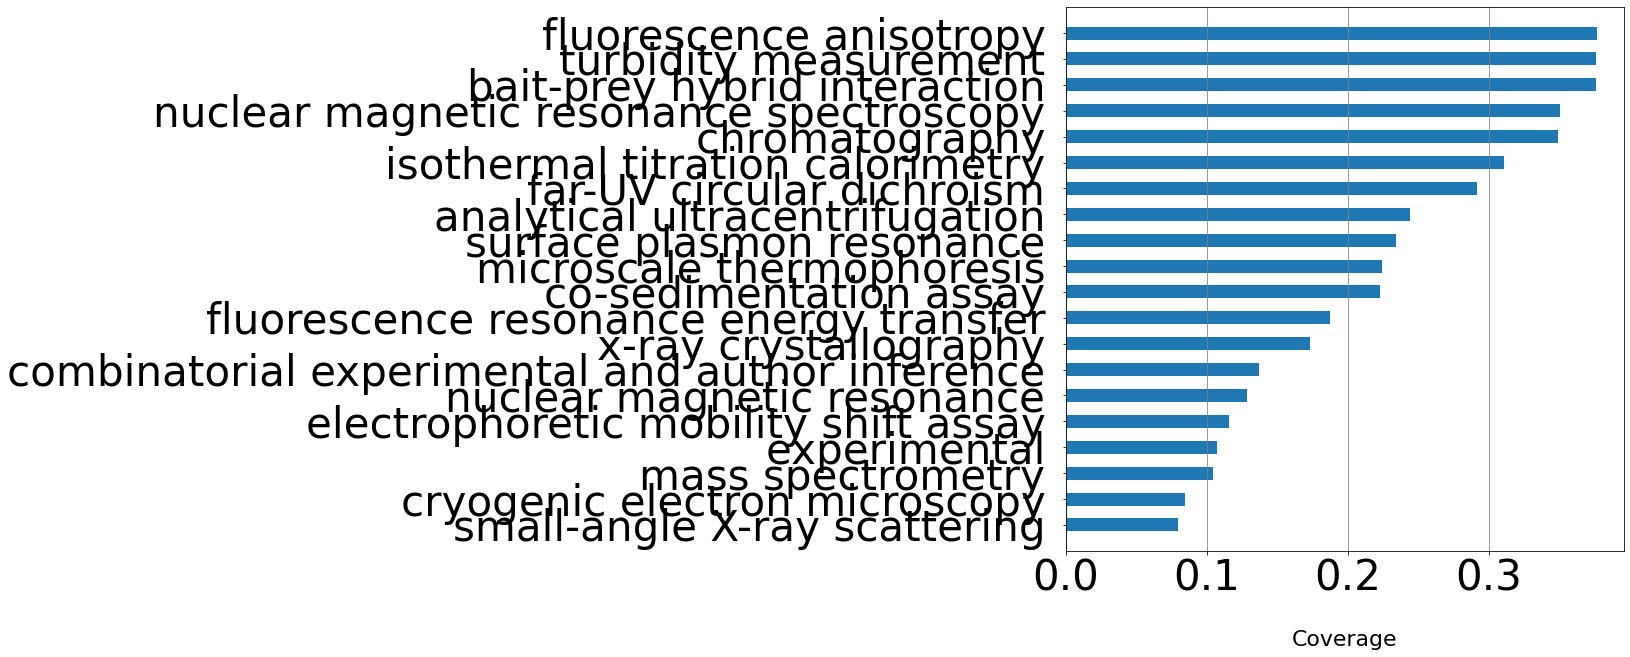

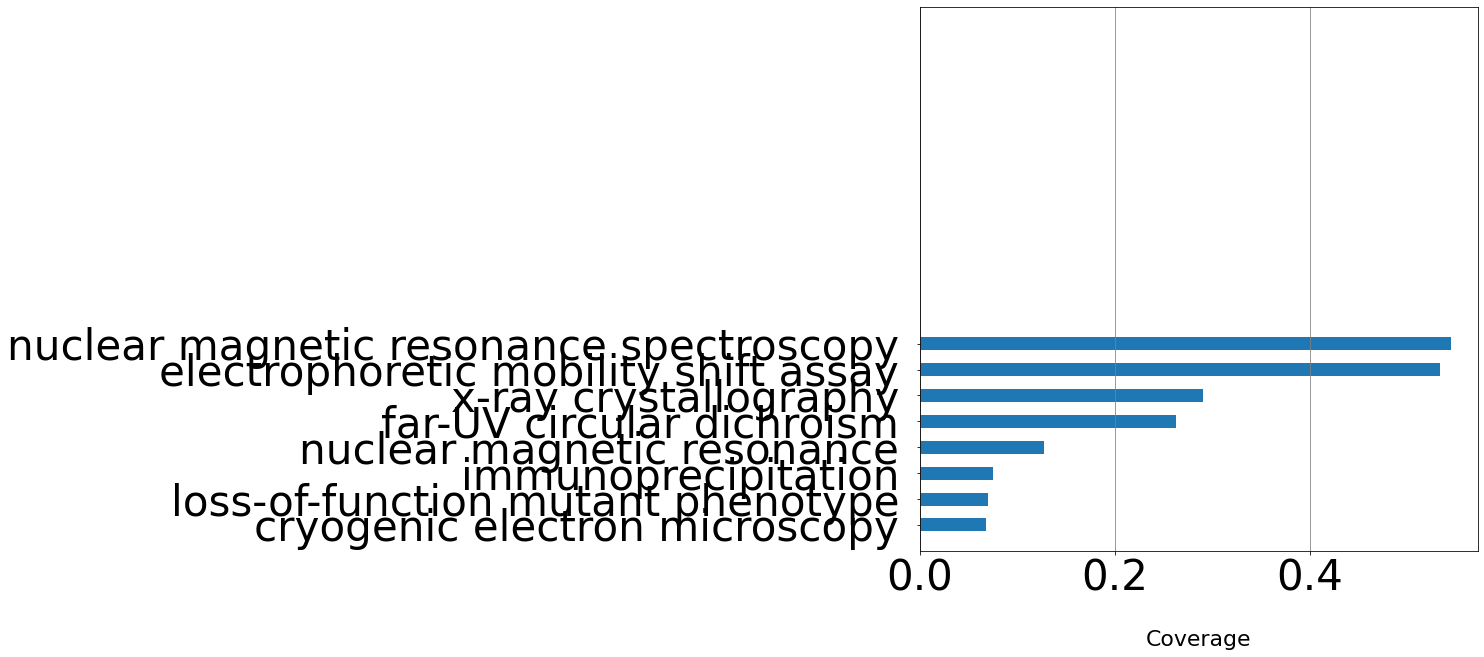

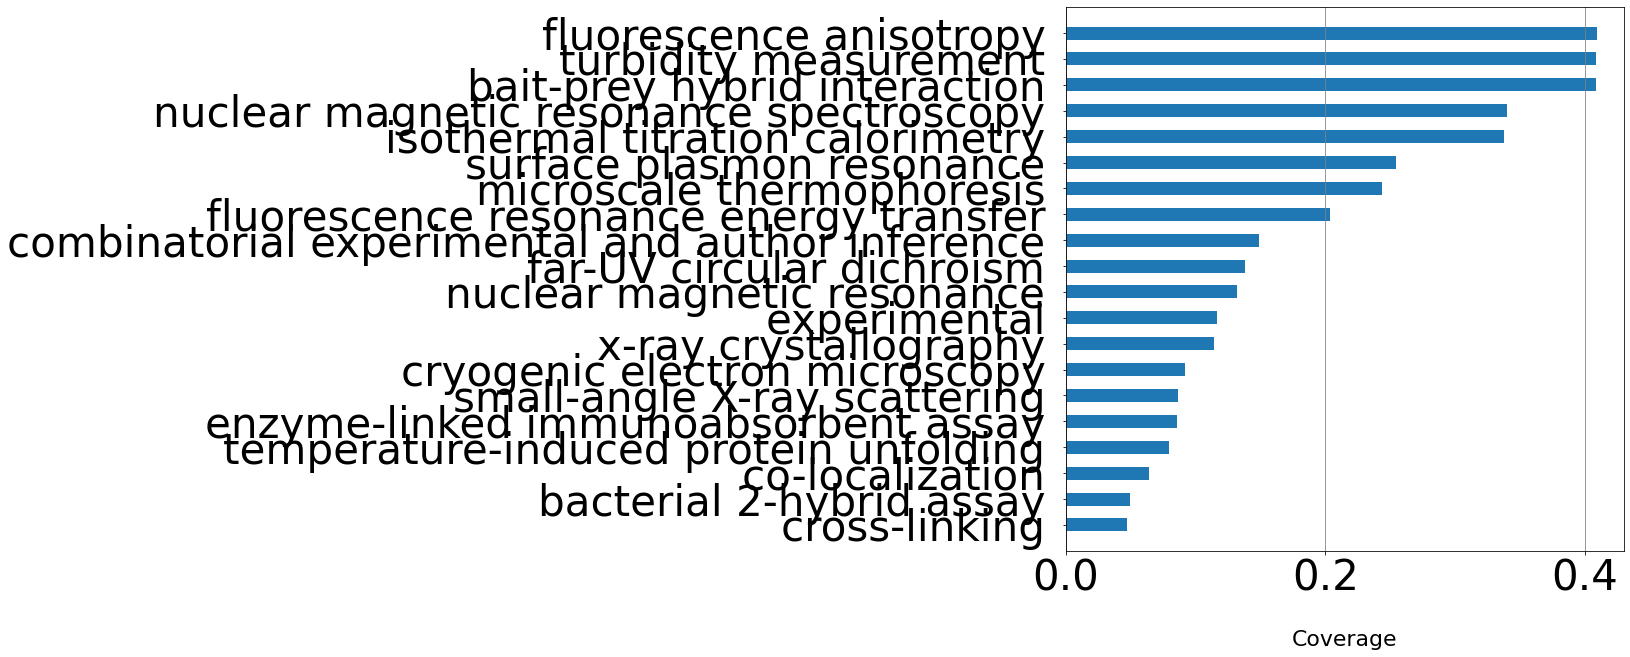

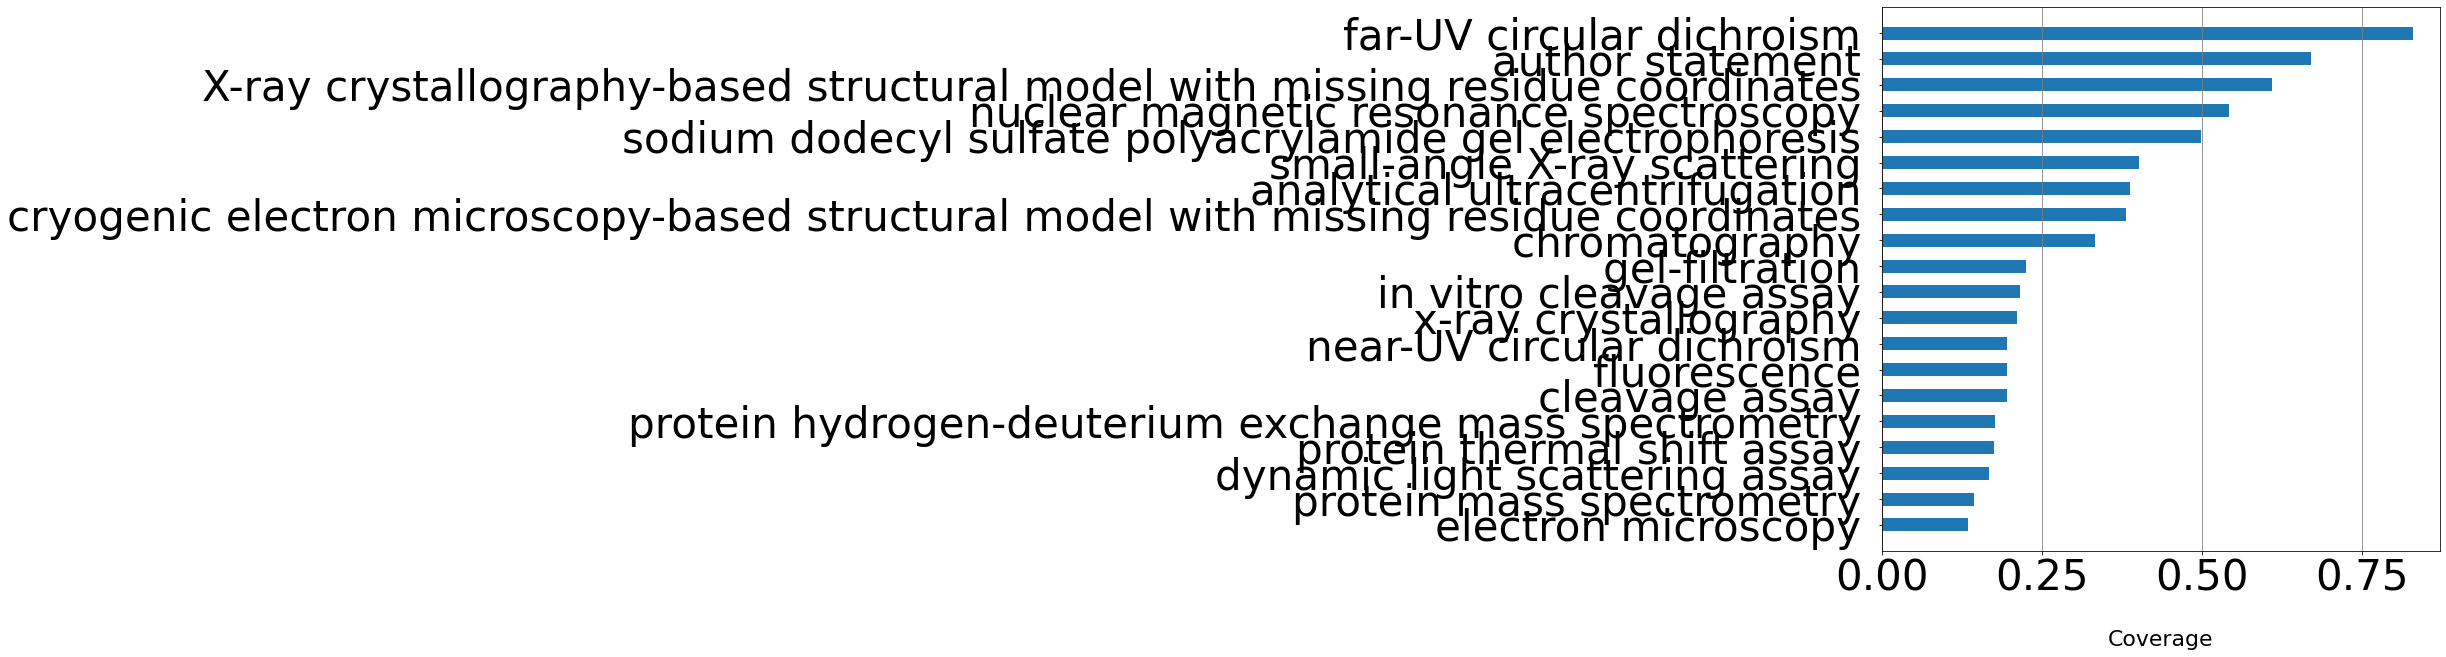

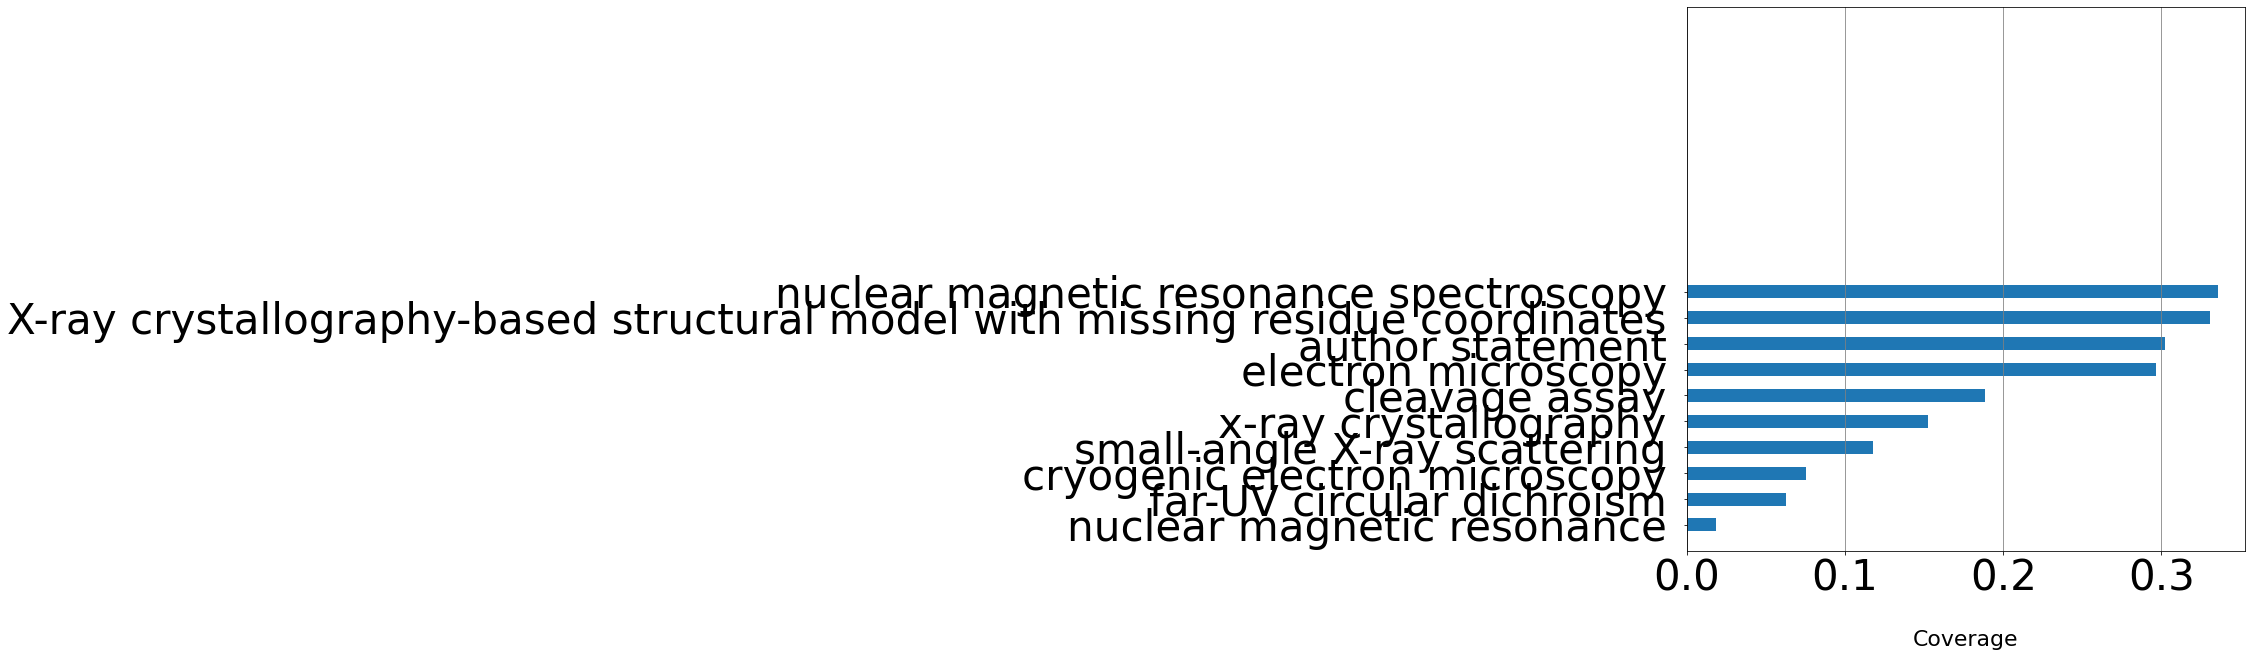

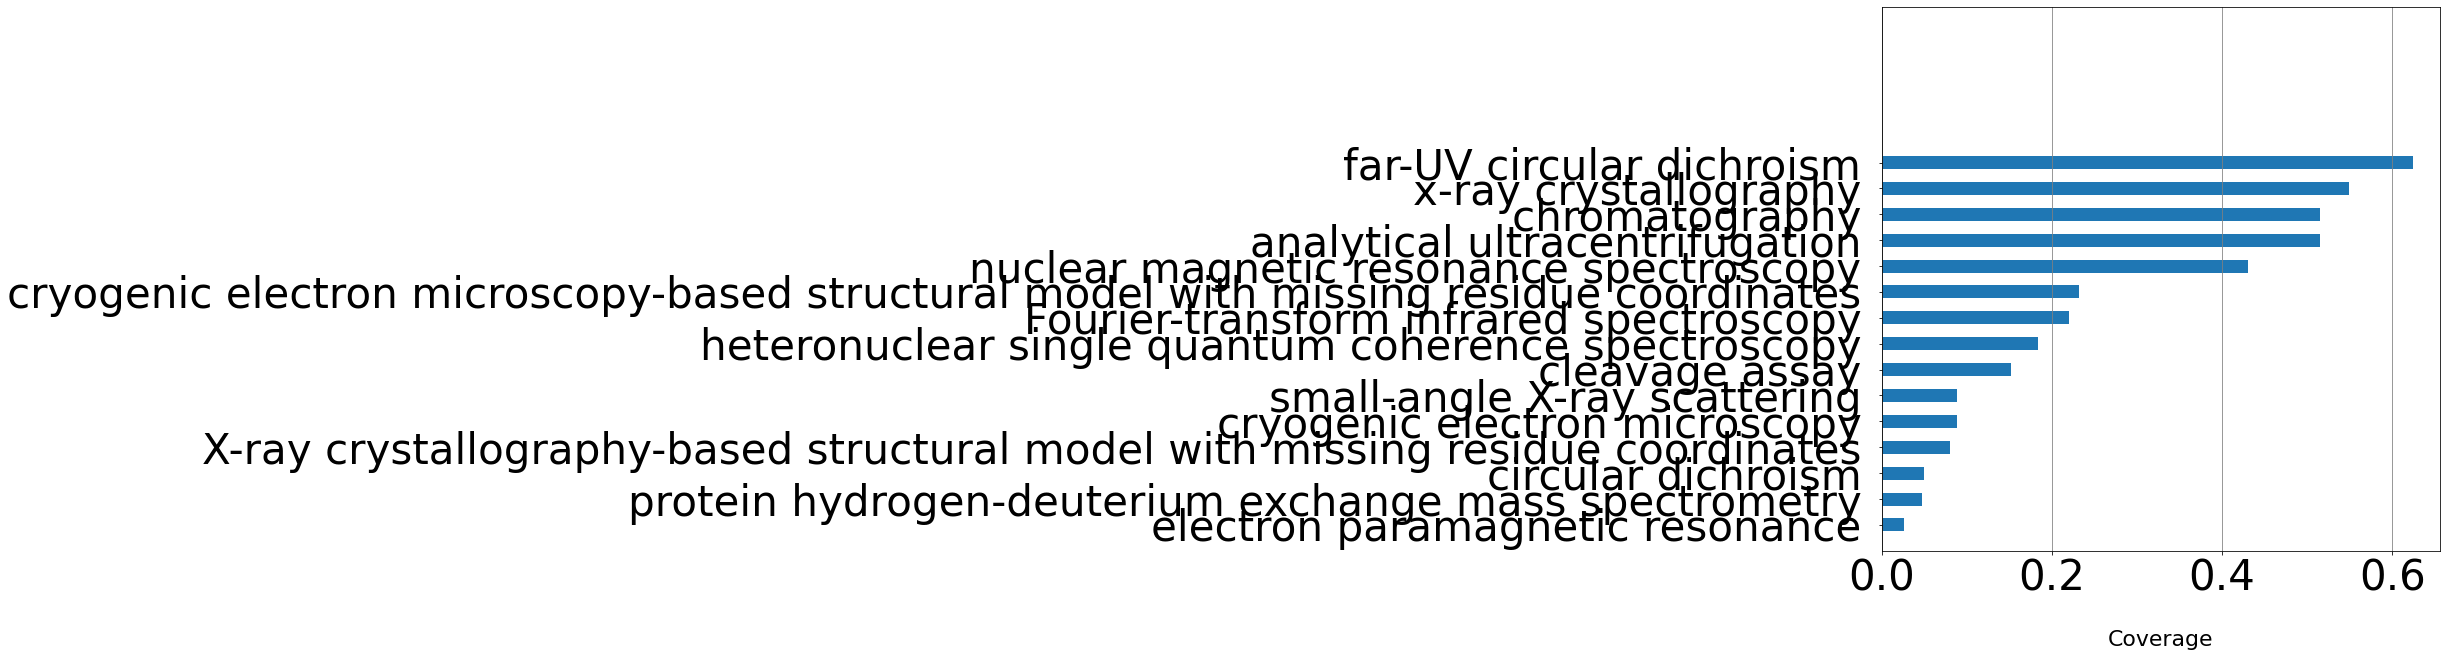

In [230]:
for challenge, df_g in df_ec.groupby('challenge'):
    fig, ax = plt.subplots(figsize=(10, 10))
    df_g['ec_name'] = df_g['ec_name'].map(lambda x: x.split('evidence')[0].split('used')[0])
    df_g.set_index('ec_name')['fraction'].iloc[-20:].plot(kind='barh', ax=ax)
    ax.xaxis.grid()
    ax.set_xlabel('Coverage', labelpad=30)

    # plt.title(challenge)
    fig.gca().set_ylabel("")
    ax.set_ybound(-1, 20)

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_ec_{}.png".format(fig_dir, challenge), dpi=300, bbox_inches='tight')
    # break

In [231]:
# ftp://ftp.ncbi.nih.gov/pub/taxonomy/new_taxdump
df_tax = pd.read_csv(ncbi_tax_file, sep="|", header=0, names=['id', '0', '1', '2', '3', '4', '5'], usecols=[0,3,4,5,6,7,9])
for i in df_tax.columns:
    if df_tax[i].dtype == 'object':
        df_tax[i] = df_tax[i].map(str.strip)
df_tax

,id,0,1,2,3,4,5
0,131567,,,,,,
1,2157,,,,,,
2,1935183,,,,,,Archaea
3,2798909,,,,,,Archaea
4,2798916,,,,,Candidatus Baldrarchaeota,Archaea
...,...,...,...,...,...,...,...
2470427,2413,,,,,,
2470428,2417,,,,,,
2470429,2414,,,,,,
2470430,2415,,,,,,


In [232]:
df_tax.loc[df_tax['id'] == 9606]

,id,0,1,2,3,4,5
813598,9606,Homo,Hominidae,Primates,Mammalia,Chordata,Eukaryota


In [233]:
df = pd.read_csv(datase_file, sep="\t")
df

,disprot_id,acc,pos,aa,disorder,linker,transition,binding nucleic acid,binding,binding protein,disorder_nox,pdb
0,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,DP02342,P06837,2,L,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,DP02342,P06837,3,C,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,DP02342,P06837,4,C,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,DP02342,P06837,5,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
287015,DP02544,Q04410,368,Q,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287016,DP02544,Q04410,369,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287017,DP02544,Q04410,370,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
287018,DP02544,Q04410,371,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [234]:
# Add taxa
df = pd.merge(df, df_dataset.loc[:,['disprot_id', 'ncbi_taxon_id']], left_on='disprot_id', right_on='disprot_id', how='left')
df

,disprot_id,acc,pos,aa,disorder,linker,transition,binding nucleic acid,binding,binding protein,disorder_nox,pdb,ncbi_taxon_id
0,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090
1,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090
2,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090
3,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090
4,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090
...,...,...,...,...,...,...,...,...,...,...,...,...,...
898857,DP02544,Q04410,371,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292
898858,DP02544,Q04410,371,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292
898859,DP02544,Q04410,372,D,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292
898860,DP02544,Q04410,372,D,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292


In [235]:
df_ = pd.merge(df, df_tax, left_on='ncbi_taxon_id', right_on='id', how='left')
df_

,disprot_id,acc,pos,aa,disorder,linker,transition,binding nucleic acid,binding,binding protein,disorder_nox,pdb,ncbi_taxon_id,id,0,1,2,3,4,5
0,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
1,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
2,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
3,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
4,DP02342,P06837,1,M,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10090,10090,Mus,Muridae,Rodentia,Mammalia,Chordata,Eukaryota
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898857,DP02544,Q04410,371,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292,559292,Saccharomyces,Saccharomycetaceae,Saccharomycetales,Saccharomycetes,Ascomycota,Eukaryota
898858,DP02544,Q04410,371,S,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292,559292,Saccharomyces,Saccharomycetaceae,Saccharomycetales,Saccharomycetes,Ascomycota,Eukaryota
898859,DP02544,Q04410,372,D,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292,559292,Saccharomyces,Saccharomycetaceae,Saccharomycetales,Saccharomycetes,Ascomycota,Eukaryota
898860,DP02544,Q04410,372,D,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,559292,559292,Saccharomyces,Saccharomycetaceae,Saccharomycetales,Saccharomycetes,Ascomycota,Eukaryota


In [236]:
challenges = ['disorder_nox', 'pdb', 'binding']
challenges_ = ['disorder_nox', 'disorder_pdb', 'binding']
df_g = df_.loc[:, challenges + ['disprot_id', '5']].drop_duplicates().groupby(['disprot_id', '5']).first().groupby('5').apply(lambda x: x.notnull().sum())
df_g

,disorder_nox,pdb,binding
5,,,
Bacteria,21,32,11
Eukaryota,169,221,57
Viruses,20,18,10


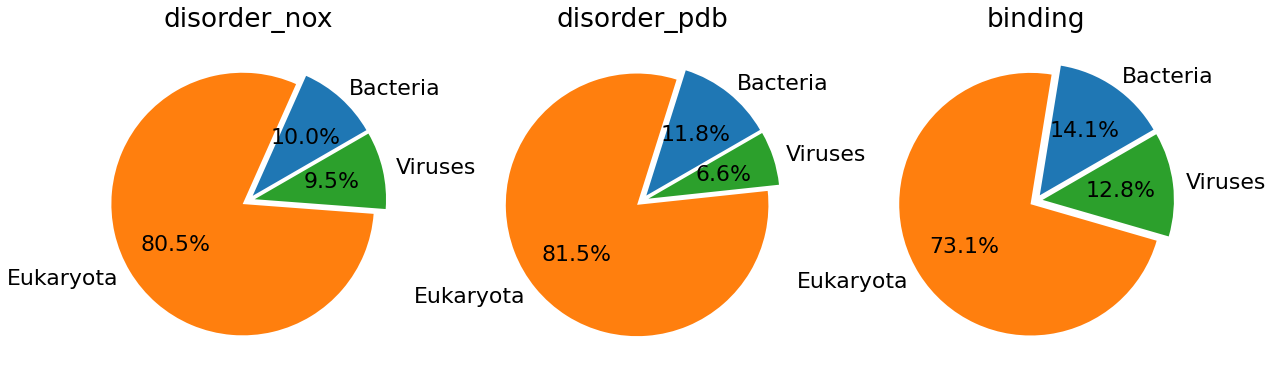

In [237]:
plt.rcParams.update({'font.size': 22, 'xtick.labelsize': 22, 'ytick.labelsize': 22})
axes = df_g.plot.pie(subplots=True, figsize=(20, 10), explode=(0.05, 0.05, 0.05), legend=False, layout=(1,3), autopct='%1.1f%%', startangle=30)
for ax, title in zip(axes.reshape(-1), challenges_):
    ax.set_title(title, pad=10, loc='center')
    ax.set_ylabel('')

plt.savefig("{}/stat_tax.png".format(fig_dir), dpi=300, bbox_inches='tight')

100 Text(-0.4578387290982591, 0.15528632127625125, '40')
101 Text(-0.36275765744303573, -0.18520716997014844, '33')
110 Text(0.09785296549032416, 0.028565064540102467, '95')
010 Text(0.4869579697169295, 0.026351783206443, '131')
001 Text(-0.3241443043600618, -0.39406770206891245, '0')
011 None
111 Text(-0.1293327685711898, -0.11753488418163899, '42')


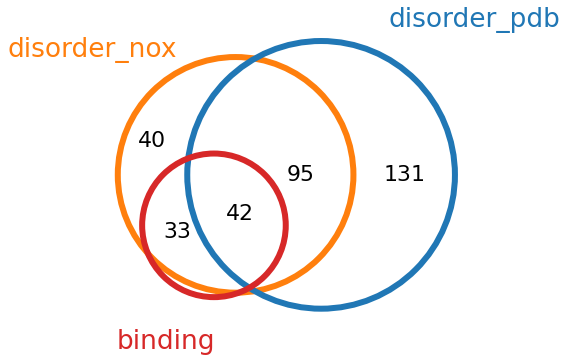

In [238]:
# https://towardsdatascience.com/professional-venn-diagrams-in-python-638abfff39cc
plt.rcParams.update({'font.size': 22, 'grid.linestyle': '-', 'grid.color': 'gray' })

from matplotlib_venn import venn3, venn3_circles

colors = ['#FF7F0D', '#2077B5', '#D72828']
labels = ['disorder_nox', 'pdb', 'binding']
labels_ = ['disorder_nox', 'disorder_pdb', 'binding']
sets = [set(df.loc[df[label].notnull(), 'disprot_id']) for label in labels]

plt.figure(figsize=(7, 7))
v = venn3(subsets=sets, set_labels=labels_, alpha=.0)

labels = ['100', '101', '110', '010', '001', '011', '111']
for label in labels:
    print(label, v.get_label_by_id(label))
v.get_label_by_id('001').set_text('')  # binding v disorder_nox
# v.get_label_by_id('pdb').set_text('disorder_pdb')  # pdb v disorder_nox


for i, (text, pos) in enumerate(zip(v.set_labels, [(1, 1), (1, 1.1), (1.8, 1.2)])):
    x, y = text.get_position()
    # print(text, x, y)
    text.set_position((x * pos[0], y * pos[1]))
    text.set_color(colors[i])

circles = venn3_circles(subsets=sets)
for color, circle in zip(colors, circles):
    circle.set_edgecolor(color)
    circle.set_linewidth(6)

plt.savefig("{}/stat_venn.png".format(fig_dir), dpi=300, bbox_inches='tight')

In [239]:
# TODO
# statistics of fully disordered proteins

In [240]:
references = ['disorder_nox', 'disorder_pdb', 'binding']
df_g = df_references.reset_index().set_index('reference')
df_g = df_g.loc[references]
df_ = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).reset_index()
df_ = df_.loc[df_['value'] != '-']#.droplevel('disprot_id').reset_index()#.pivot(index='reference', columns='value', values='pos')
df_tot = df_.groupby(['disprot_id', 'reference']).agg({'pos': 'sum'})
df_ = pd.merge(df_, df_tot, on=['disprot_id', 'reference'])
df_['fraction'] = df_['pos_x'] / df_['pos_y']
df_


,disprot_id,reference,value,pos_x,pos_y,fraction
0,DP02342,binding,0,203,227,0.894273
1,DP02342,binding,1,24,227,0.105727
2,DP02342,disorder_nox,1,227,227,1.000000
3,DP02342,disorder_pdb,1,227,227,1.000000
4,DP02348,binding,0,385,415,0.927711
...,...,...,...,...,...,...
1139,DP03744,disorder_nox,0,104,178,0.584270
1140,DP03744,disorder_nox,1,74,178,0.415730
1141,DP03744,disorder_pdb,0,88,162,0.543210
1142,DP03744,disorder_pdb,1,74,162,0.456790


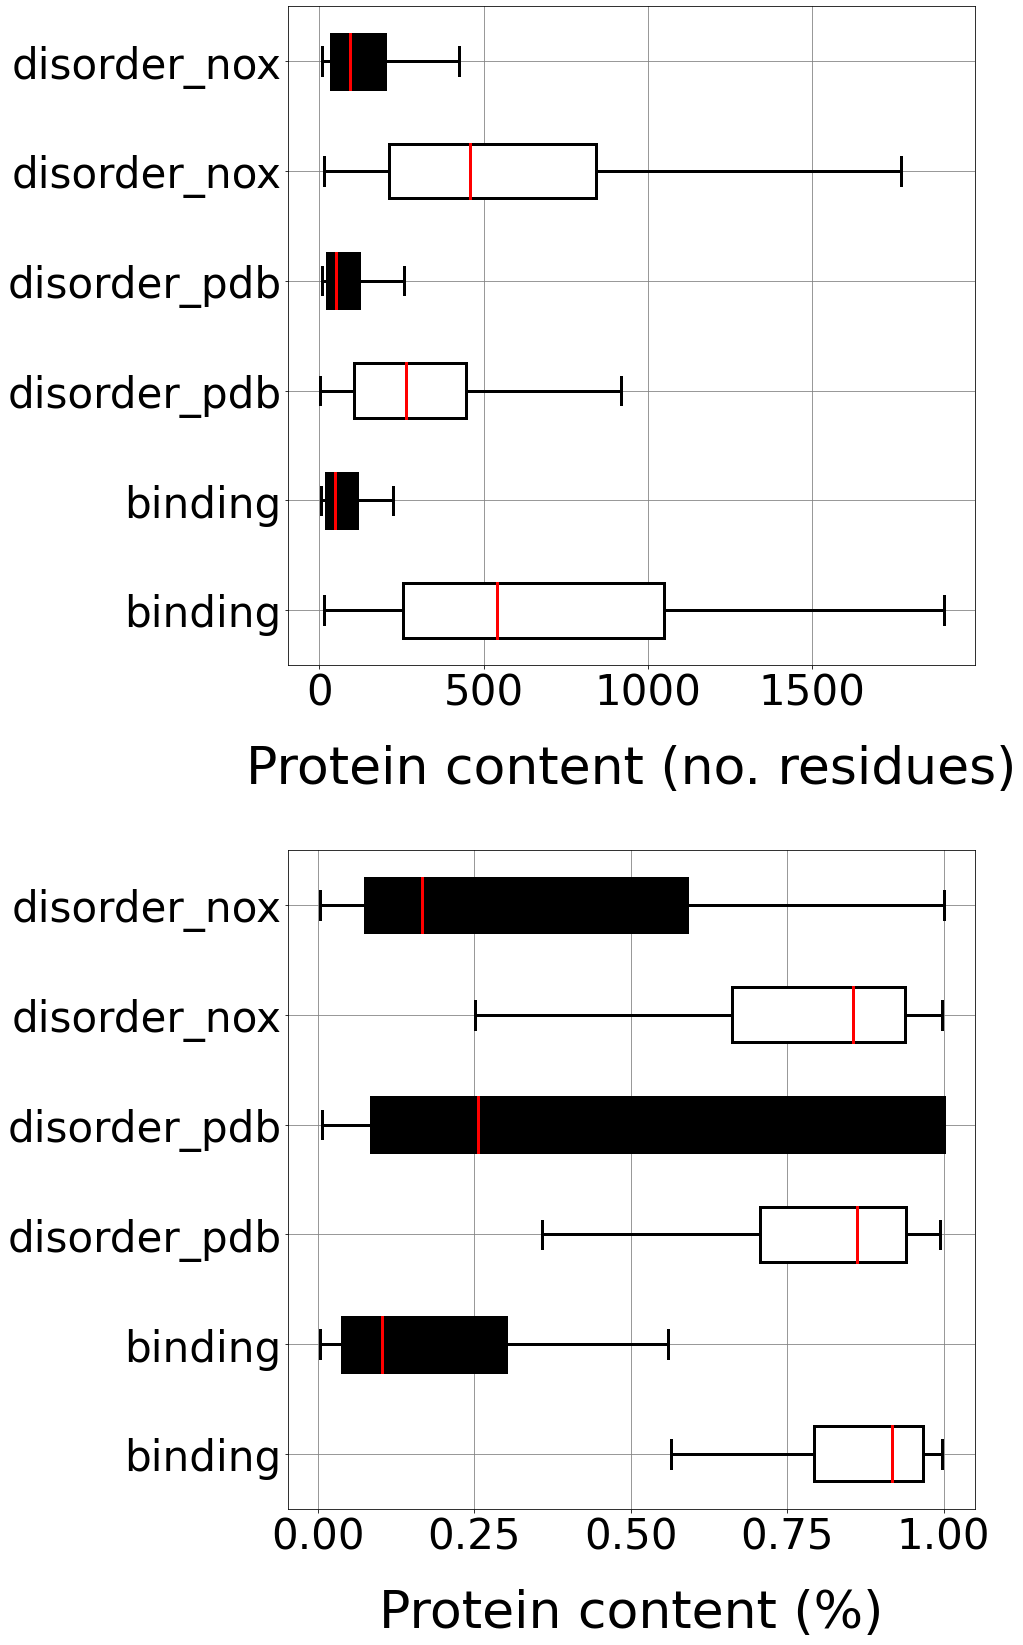

In [273]:
# Paper figure disorder content
plt.rcParams.update({'font.size': 52, 'savefig.transparent': True})

positions = [0,1,4,5,2,3]
# colors = {'0': '#1f77b4', '1': '#ff7f0e'}
colors = {'0': 'white', '1': 'black'}

fig, axes = plt.subplots(2,1, figsize=(15, 25))

bp = df_.loc[:, ['reference', 'value', 'pos_x']].boxplot(by=['reference', 'value'], ax=axes[0], vert=False, positions=positions, showfliers=False, return_type='dict', patch_artist=True, whiskerprops=dict(linestyle='-',linewidth=3.0, color='black'), medianprops=dict(linewidth=3.0, color='red'), boxprops=dict(linewidth=3.0, color='black'), capprops=dict(linewidth=3.0))

bp_fraction = df_.loc[:, ['reference', 'value', 'fraction']].boxplot(by=['reference', 'value'], ax=axes[1], vert=False, positions=positions, showfliers=False, return_type='dict', patch_artist=True, whiskerprops=dict(linestyle='-',linewidth=3.0, color='black'), medianprops=dict(linewidth=3.0, color='red'), boxprops=dict(linewidth=3.0, color='black'), capprops=dict(linewidth=3.0))

for ax in axes:
    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)
    ax.set_ylabel("")
    ax.get_figure().suptitle('')
    ax.set_title("")

axes[1].set_xlabel('Protein content (%)', labelpad=30)
axes[0].set_xlabel('Protein content (no. residues)', labelpad=30)

# Bar colors
for patch, (label, df_g) in zip(bp_fraction['fraction']['boxes'], df_.groupby(['reference', 'value'])):
    patch.set_facecolor(colors[label[1]])
positive = mpatches.Patch(label='Positive', color=colors['1'])
negative = mpatches.Patch(label='Negative', color=colors['0'])

for patch, (label, df_g) in zip(bp['pos_x']['boxes'], df_.groupby(['reference', 'value'])):
    patch.set_facecolor(colors[label[1]])
positive = mpatches.Patch(label='Positive', color=colors['1'])
negative = mpatches.Patch(label='Negative', color=colors['0'])

# Legend
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles=[positive, negative], loc='upper center', ncol=2, bbox_to_anchor=(.6, 1.0), frameon=False)
fig.tight_layout()
fig.savefig("{}/stat_content_paper.png".format(fig_dir), dpi=300, bbox_inches='tight')

In [242]:
df_g = df_ec.loc[df_ec['challenge'] == 'disorder']
df_g['ec_name'] = df_g['ec_name'].map(lambda x: x.split('evidence')[0].split('used')[0])
df_g['ec_name'] = df_g['ec_name'].map(lambda x: " ".join(x.split()[:4]) + "\n" + " ".join(x.split()[4:]))
df_g = df_g.set_index('ec_name').sort_values(by='fraction', ascending=False)
df_g

/tmp/ipykernel_23435/47701083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g['ec_name'] = df_g['ec_name'].map(lambda x: x.split('evidence')[0].split('used')[0])
/tmp/ipykernel_23435/47701083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g['ec_name'] = df_g['ec_name'].map(lambda x: " ".join(x.split()[:4]) + "\n" + " ".join(x.split()[4:]))


,challenge,count,total,fraction
ec_name,,,,
far-UV circular dichroism\n,disorder,2128,2563,0.830277
author statement\n,disorder,1720,2563,0.671089
X-ray crystallography-based structural model\nwith missing residue coordinates,disorder,1561,2563,0.609052
nuclear magnetic resonance spectroscopy\n,disorder,1389,2563,0.541943
sodium dodecyl sulfate polyacrylamide\ngel electrophoresis,disorder,1280,2563,0.499415
small-angle X-ray scattering\n,disorder,1032,2563,0.402653
analytical ultracentrifugation\n,disorder,993,2563,0.387437
cryogenic electron microscopy-based structural\nmodel with missing residue coordinates,disorder,977,2563,0.381194
chromatography\n,disorder,856,2563,0.333984


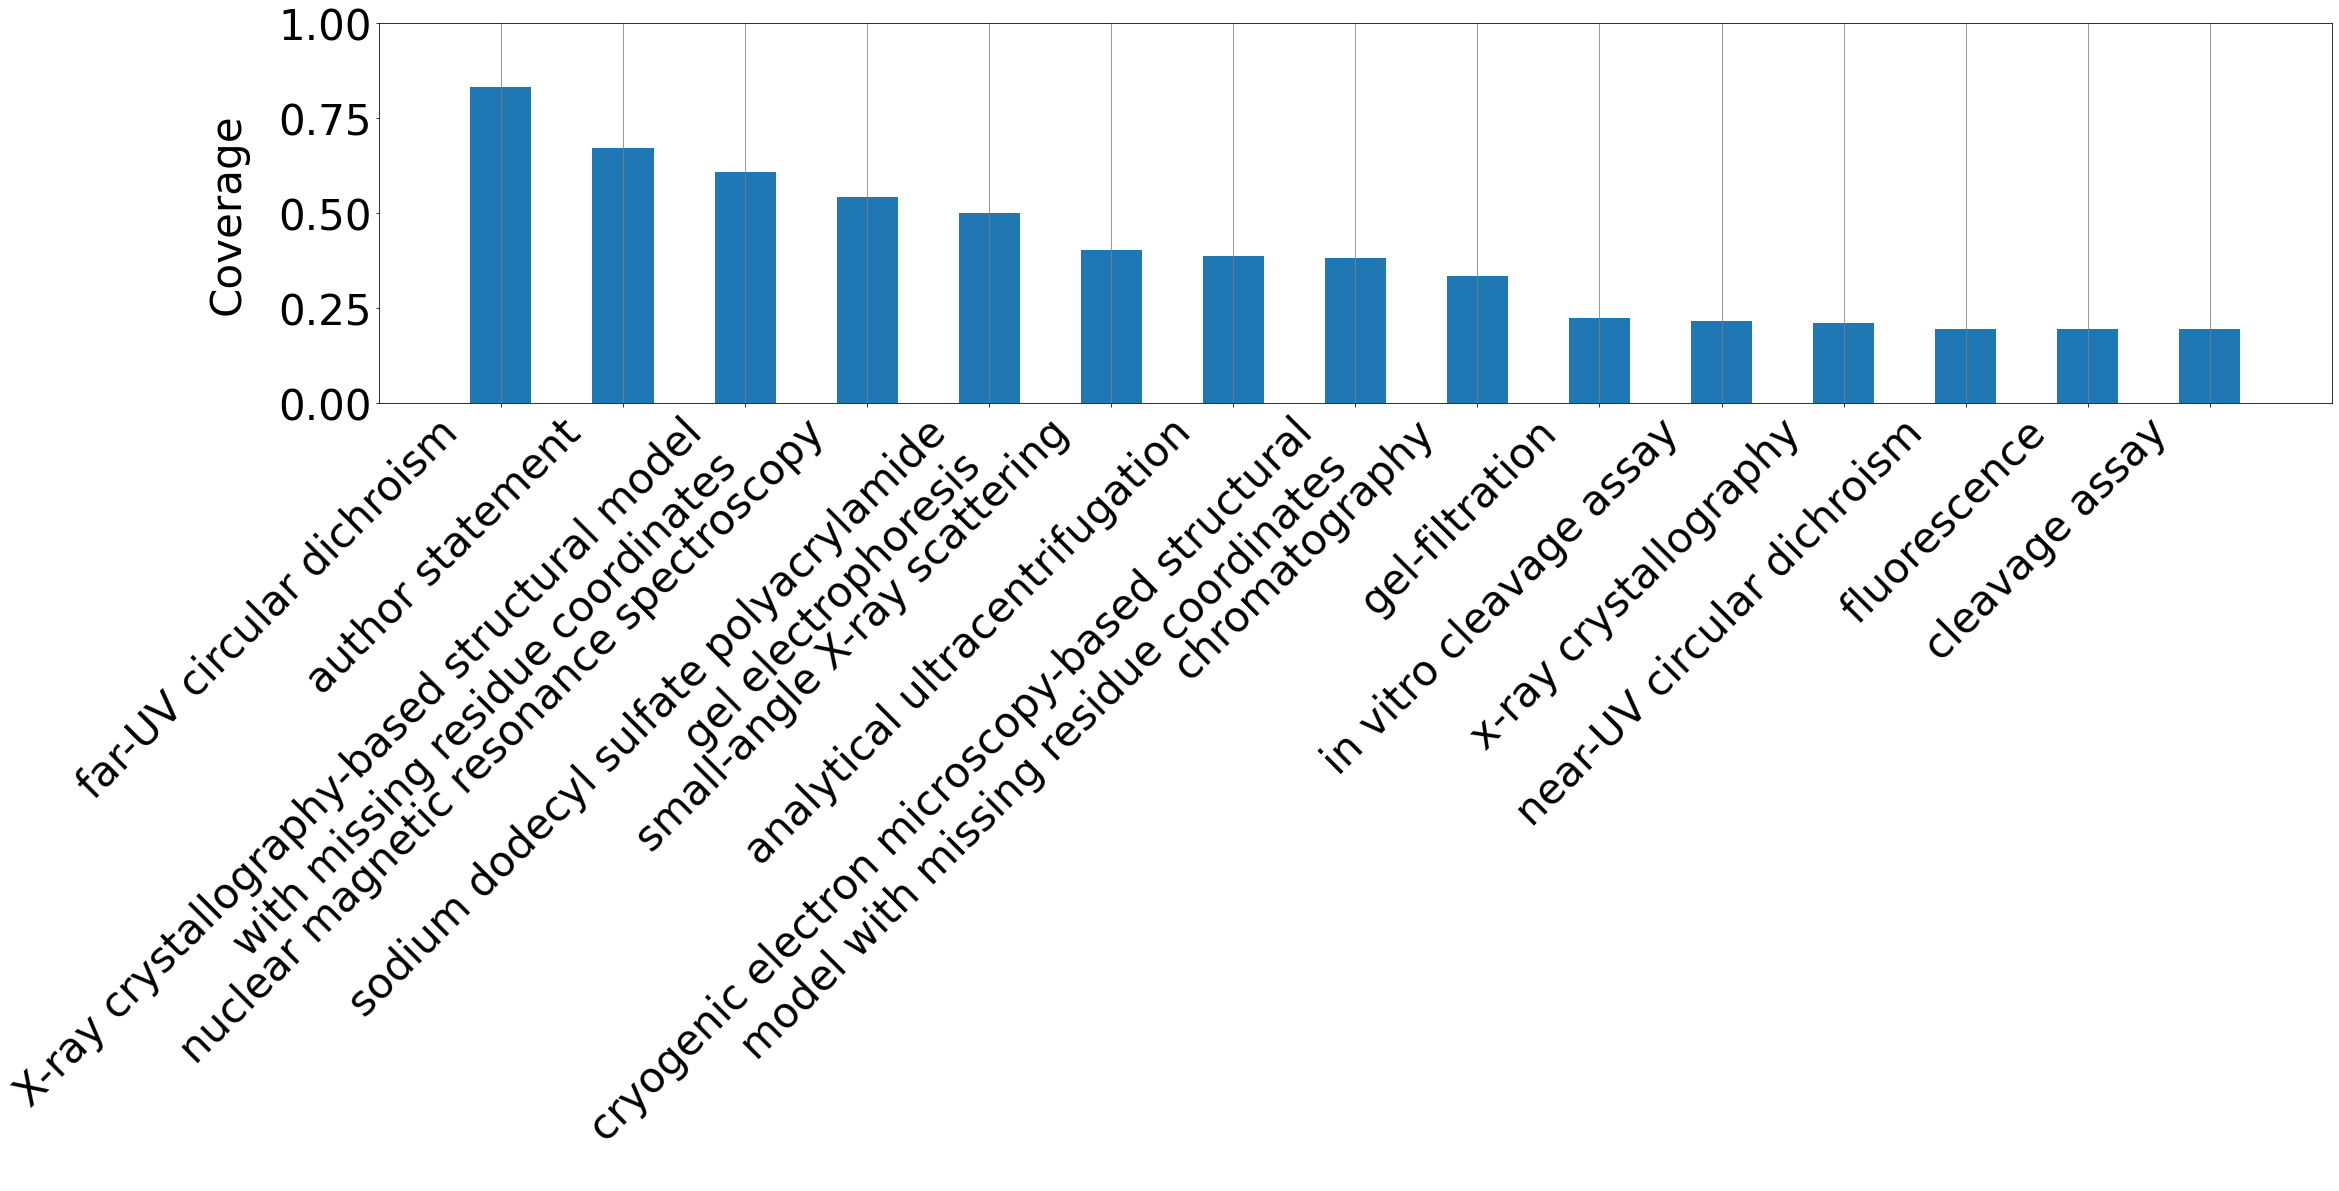

In [243]:
plt.rcParams.update({'font.size': 42, 'savefig.transparent': True, 'xtick.labelsize': 42, 'ytick.labelsize': 42})

fig, ax = plt.subplots(figsize=(35, 7))

df_g['fraction'].iloc[:15].plot(kind='bar', ax=ax, align='center')
ax.xaxis.grid()
ax.set_ylabel('Coverage', labelpad=30)
plt.xticks(rotation = 45, ha='right')

# plt.title(challenge)
fig.gca().set_xlabel("")
ax.set_xbound(-1, 15)
ax.set_ybound(0, 1)

fig.gca().set_xlabel("")
fig.savefig("{}/stat_ec_{}_vertical.png".format(fig_dir, challenge), dpi=300, bbox_inches='tight')

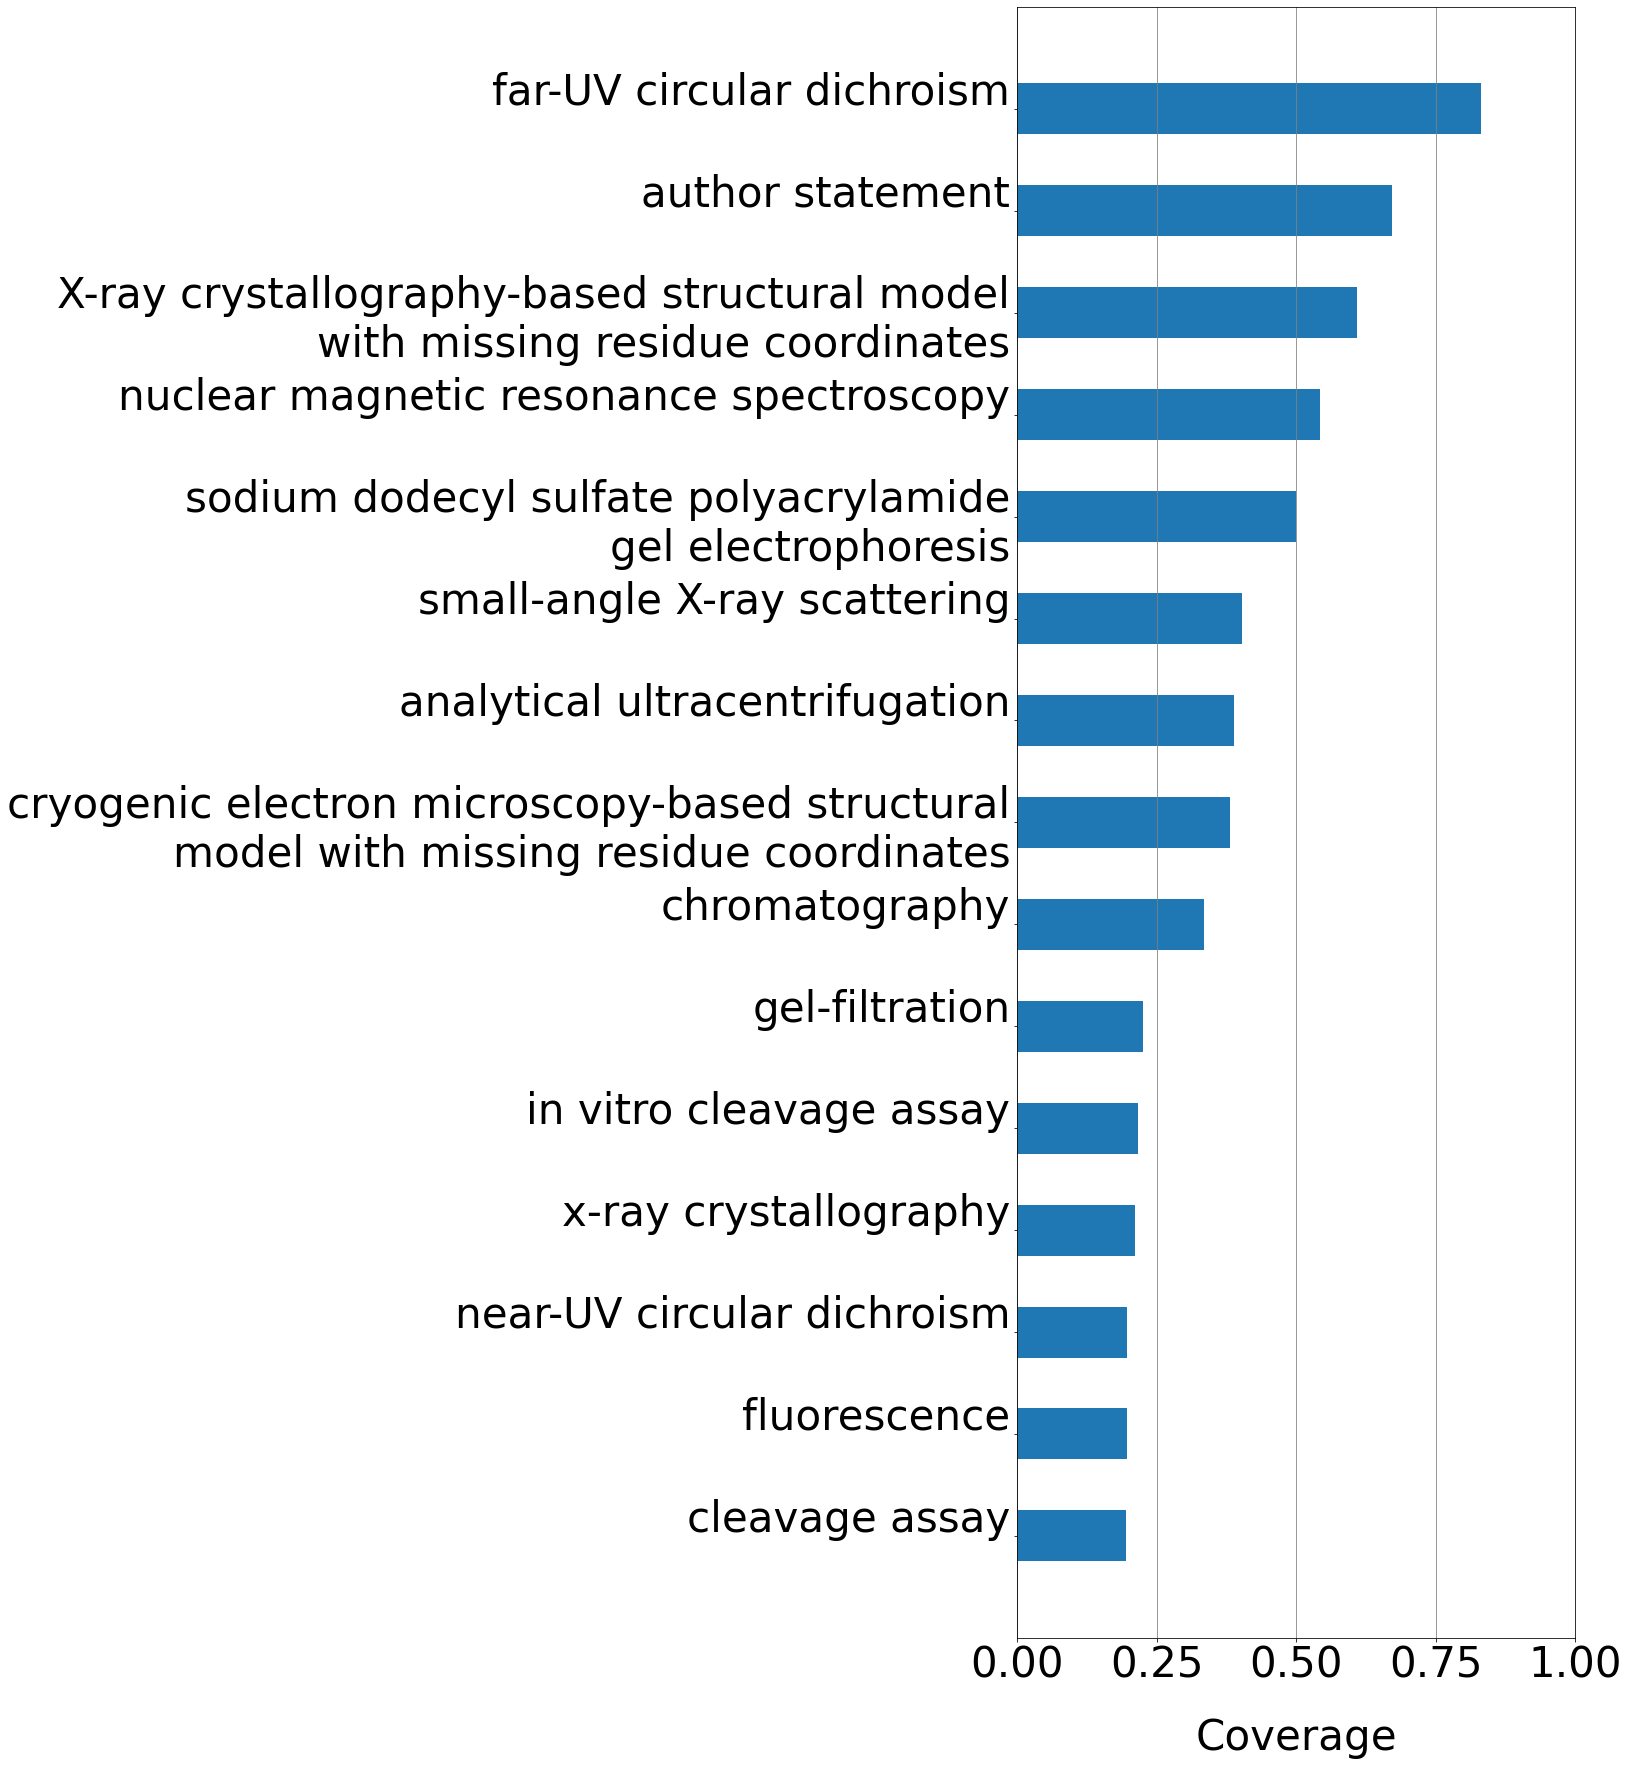

In [244]:
plt.rcParams.update({'font.size': 42, 'savefig.transparent': True, 'xtick.labelsize': 42, 'ytick.labelsize': 42})

fig, ax = plt.subplots(figsize=(10, 30))

df_g.sort_values(by='fraction', ascending=True)['fraction'].iloc[-15:].plot(kind='barh', ax=ax, align='center')
ax.xaxis.grid()
ax.set_xlabel('Coverage', labelpad=30)
plt.yticks(ha='right')

# plt.title(challenge)
fig.gca().set_ylabel("")
ax.set_ybound(-1, 15)
ax.set_xbound(0, 1)

fig.gca().set_ylabel("")
fig.savefig("{}/stat_ec_{}_horizonatal.png".format(fig_dir, challenge), dpi=300, bbox_inches='tight')